# DATA WRANGLING & EDA


In [1]:
# Imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import re
from wordcloud import WordCloud

# NLP import
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec

**DATASET provided consists of 12,500 positive (score >= 7) and 12,500 negative (score <= 4) reviews from IMBD**
- http://ai.stanford.edu/~amaas/data/sentiment/
- originally 50,000 separate .txt files --> compiled into Excel queries --> saved as UTF-8 CSV


In [115]:
# Reviewing data -- no nulls, correct dtypes
df = pd.read_csv('../datasets/train.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   positive  25000 non-null  int64 
 1   text      25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [116]:
df.head()

,positive,text
0,1,Bromwell High is a cartoon comedy. It ran at t...
1,1,Homelessness (or Houselessness as George Carli...
2,1,Brilliant over-acting by Lesley Ann Warren. Be...
3,1,This is easily the most underrated film inn th...
4,1,This is not the typical Mel Brooks film. It wa...


In [117]:
# Confirmed only 2 classes for positive
df['positive'].unique()

array([1, 0])

In [118]:
# Equal distribution as per normalize=al source
df['positive'].value_counts(normalize=True)

1    0.5
0    0.5
Name: positive, dtype: float64

In [119]:
# Clean text method
def cleaner(text):
    
    # Remove any HTML tags in-case
    text = BeautifulSoup(text, features='lxml').get_text()
    
    # Type and lower-cased
    text = str(text)
    text = text.lower()
    
    # Replace "n't" with " not"
        # Doesn’t, Isn’t, Wasn’t, Shouldn’t, Wouldn’t, Couldn’t, Won’t, Can’t, Don’t
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    
    # Join negatives "not" or "no" with next word
    text = re.sub("not ", " NOT", text)
    text = re.sub("no ", " NO", text)
    
    # Remove non-alphabets
    text = re.sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    
    # Extra cleaning beyond bs4
    text = re.sub(r"\+", " plus ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\?", " ? ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    return text

In [120]:
# Cleaned
df['text'] = df['text'].apply(cleaner)
df.head()

,positive,text
0,1,bromwell high is a cartoon comedy it ran at th...
1,1,homelessness or houselessness as george carlin...
2,1,brilliant over acting by lesley ann warren bes...
3,1,this is easily the most underrated film inn th...
4,1,this is NOTthe typical mel brooks film it was ...


In [121]:
df.to_csv('../datasets/train_cleaned.csv', index=False)

In [122]:
# Top 30 words -- positive
cvec = CountVectorizer(ngram_range=(1,2), stop_words='english', max_features=30)

postives = df[df['positive']==1]['text']

# Count stored into DataFrame for analysis
positive30 = pd.DataFrame(cvec.fit_transform(postives).toarray(),
                          columns = cvec.get_feature_names_out())

# Top 20 words and frequencies
positive30.sum().sort_values(ascending=False)

film          20921
movie         18983
like           8550
good           7650
story          6765
just           6761
time           6479
great          6321
does           4984
really         4903
people         4470
did            4453
best           4317
love           4244
life           4191
way            3940
films          3804
movies         3570
characters     3550
character      3505
man            3450
little         3333
watch          3296
think          3230
make           3075
seen           3009
years          2754
end            2659
scene          2561
real           2486
dtype: int64

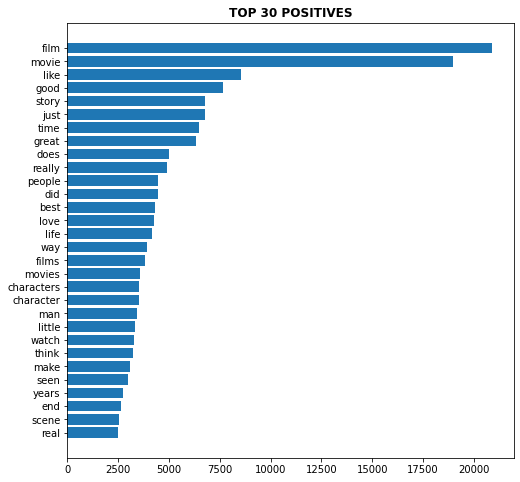

In [195]:
# Horizontal bar chart for visual
positive30_sorted = positive30.sum().sort_values(ascending=False)

plt.figure(figsize=(8,8))
plt.title('TOP 30 POSITIVES', weight='bold')
plt.barh(positive30_sorted.index, positive30_sorted)
plt.gca().invert_yaxis()
plt.savefig('../images/postive30.png', dpi=75)

In [124]:
# Top 30 words -- negative
negatives = df[df['positive']==0]['text']

# Count stored into DataFrame for analysis
negative30 = pd.DataFrame(cvec.fit_transform(negatives).toarray(),
                          columns = cvec.get_feature_names_out())

# Top 20 words and frequencies
negative30.sum().sort_values(ascending=False)

movie         24881
film          19177
like          10821
just          10301
bad            7196
good           7187
time           6151
did            6139
really         5531
does           5464
story          5136
people         4798
make           4171
movies         4069
acting         4007
plot           3992
way            3825
characters     3578
character      3439
better         3303
watch          3229
think          3133
little         3088
films          3072
seen           3025
end            2895
thing          2856
ve             2843
scene          2801
say            2771
dtype: int64

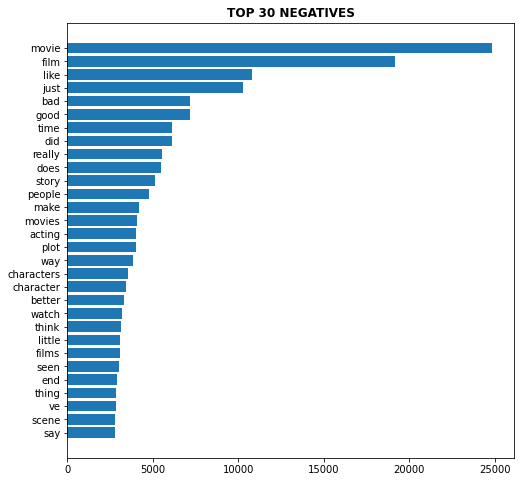

In [196]:
# Horizontal bar chart for visual
negative30_sorted = negative30.sum().sort_values(ascending=False)

plt.figure(figsize=(8,8))
plt.title('TOP 30 NEGATIVES', weight='bold')
plt.barh(negative30_sorted.index, negative30_sorted)
plt.gca().invert_yaxis()
plt.savefig('../images/negative30.png', dpi=75)

In [126]:
# Common words between both top 30 +ve & -ve
for n in negative30.columns:
    if n in positive30.columns:
        print(n)

character
characters
did
does
end
film
films
good
just
like
little
make
movie
movies
people
really
scene
seen
story
think
time
watch
way


## COMMON 1-GRAM WORDS IN POSITIVE VS NEGATIVE:
- Despit the following words being common accross both sentiments, we'll retain them for as there may be multi-gram combinations that are prominent within each sentiment:
    - character
    - characters
    - did
    - does
    - end
    - film (TOP)
    - films
    - good (TOP)
    - just (TOP)
    - know
    - like (TOP)
    - little
    - make
    - movie (TOP)
    - movies
    - people
    - really
    - seen
    - story
    - think
    - time (TOP)
    - watch
    - way

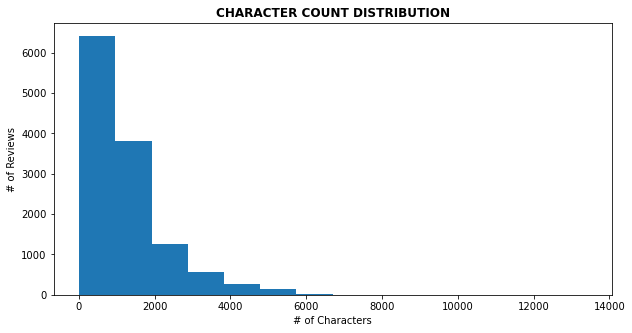

In [86]:
# Distribution - Number of characters per review
plt.figure(figsize=(10,5))
plt.hist(positives.str.len(), bins=14)
plt.title('CHARACTER COUNT DISTRIBUTION', weight='bold')
plt.ylabel('# of Reviews')
plt.xlabel('# of Characters')

plt.savefig('../images/char_distr.png');

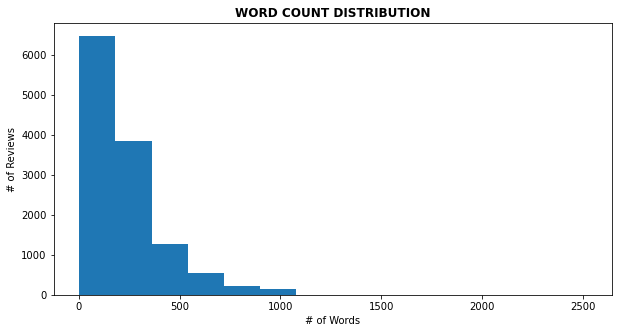

In [87]:
# Distribution - Number of characters per review
plt.figure(figsize=(10,5))
plt.hist(positives.str.split().apply(len), bins=14)
plt.title('WORD COUNT DISTRIBUTION', weight='bold')
plt.ylabel('# of Reviews')
plt.xlabel('# of Words')

plt.savefig('../images/word_distr.png');

In [78]:
print(f'Average characters: {positives.str.len().mean()}')
print(f'Average words: {positives.str.split().apply(len).mean()}')

Average characters: 1292.32144
Average words: 239.30712


## OBSERVATION
- The majority of reviews were within the:
    - 2000 character count -- averaging 1290 characters per review
    - 500 word count -- averaging 240 words per review

## WORD CLOUD

In [ ]:
from wordcloud import WordCloud

In [14]:
# Combined all positive reviews & all negative reviews
df_grouped= df.groupby(by='positive').agg(lambda x:' '.join(x))
df_grouped.head()

,text
positive,
0,story of a man who has unnatural feelings for ...
1,bromwell high is a cartoon comedy it ran at th...


In [41]:
# Redefine vectorizer without max features
cvec = CountVectorizer(ngram_range=(1,2), stop_words='english')

# Refit & transform positive/negative reviews
df_vec = pd.DataFrame(cvec.fit_transform(df_grouped['text']).toarray(),
                          columns = cvec.get_feature_names())

df_vec.index = ['negative', 'positive']
df_vec.head()

,00,00 01,00 90,00 air,00 alison,00 bargain,00 big,00 bin,00 brief,00 budget,...,zzzzzzzz,zzzzzzzz expecting,zzzzzzzzzzzzpop,zzzzzzzzzzzzpop vcr,zzzzzzzzzzzzz,zzzzzzzzzzzzz youth,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz ooops,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz spoilers
negative,51,0,1,1,0,0,0,2,0,1,...,1,1,1,1,1,1,1,1,1,1
positive,42,1,0,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# Transposing document term matrix
    # sentiments = column
    # word = index
df_vec = df_vec.transpose()
df_vec.head()

,negative,positive
00,51,42
00 01,0,1
00 90,1,0
00 air,1,0
00 alison,0,1


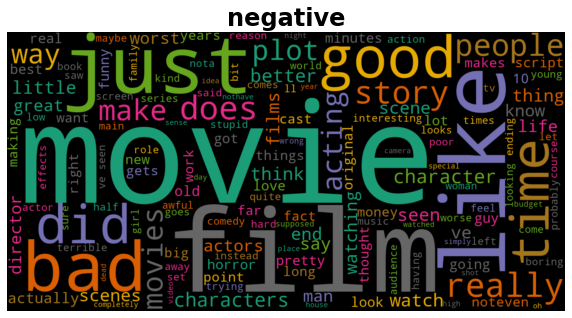

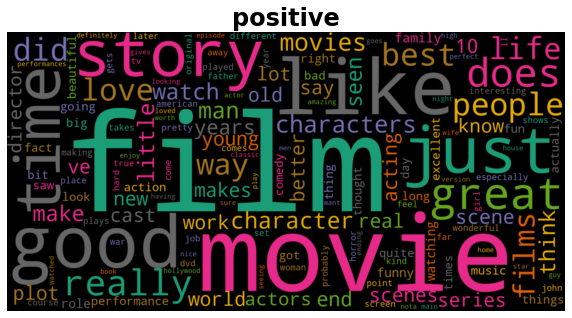

In [101]:
def generate_wordcloud(data, title):
    wc = WordCloud(width=1500, height=750, max_words=150, colormap="Dark2").generate_from_frequencies(data)
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=24, weight='bold')
    plt.show()
    
    return wc
      
# Plotting word cloud for each product
for sentiment in df_vec.columns:
    wc = generate_wordcloud(df_vec[sentiment].sort_values(ascending=False), sentiment)
    wc.to_file(f'../images/wordcloud_{sentiment}.png')

### WORD2VEC MODELING

In [192]:
# Training w2v model
w2v_model = Word2Vec(df['text'].apply(word_tokenize),
                     epochs=10,
                     workers=3,
                     vector_size=300,
                     window=5,
                     min_count=2)

keyed_vectors = w2v_model.wv
keyed_vocab = keyed_vectors.key_to_index

In [193]:
# Positive words
keyed_vectors.most_similar('good', topn=30)

[('decent', 0.7113761901855469),
 ('cool', 0.5977899432182312),
 ('great', 0.5930113196372986),
 ('bad', 0.5690209269523621),
 ('nice', 0.5651700496673584),
 ('NOTbad', 0.54172283411026),
 ('fine', 0.5387140512466431),
 ('interesting', 0.5277673006057739),
 ('mediocre', 0.5260066986083984),
 ('ok', 0.5208632946014404),
 ('terrific', 0.51324862241745),
 ('lousy', 0.5051515698432922),
 ('solid', 0.5045264363288879),
 ('okay', 0.5033777356147766),
 ('funny', 0.5010479092597961),
 ('impressive', 0.49961310625076294),
 ('weak', 0.49555832147598267),
 ('excellent', 0.4938136339187622),
 ('NOTgood', 0.49080559611320496),
 ('fantastic', 0.49024733901023865),
 ('terrible', 0.4899883568286896),
 ('strong', 0.4892074167728424),
 ('scary', 0.47914713621139526),
 ('awesome', 0.4771000146865845),
 ('lame', 0.47227999567985535),
 ('cheesy', 0.468642920255661),
 ('poor', 0.46460050344467163),
 ('watchable', 0.4626845419406891),
 ('passable', 0.46262139081954956),
 ('pleasant', 0.4603581130504608)]

In [194]:
# Negative words
keyed_vectors.most_similar('bad', topn=30)

[('terrible', 0.660362958908081),
 ('horrible', 0.6246383190155029),
 ('awful', 0.5915163159370422),
 ('good', 0.5690208673477173),
 ('cheesy', 0.5582769513130188),
 ('lame', 0.5519356727600098),
 ('stupid', 0.5496534705162048),
 ('lousy', 0.5056127309799194),
 ('atrocious', 0.5018506646156311),
 ('corny', 0.49811670184135437),
 ('laughable', 0.49656248092651367),
 ('dreadful', 0.49100178480148315),
 ('poor', 0.4840869903564453),
 ('dumb', 0.4775286614894867),
 ('weak', 0.4750647246837616),
 ('mediocre', 0.4694470763206482),
 ('obvious', 0.464299738407135),
 ('horrendous', 0.4533825218677521),
 ('pathetic', 0.4526937007904053),
 ('amateurish', 0.44794753193855286),
 ('crappy', 0.4472980499267578),
 ('ridiculous', 0.43687909841537476),
 ('predictable', 0.43607908487319946),
 ('ok', 0.4350636601448059),
 ('dire', 0.4342940151691437),
 ('abysmal', 0.42588722705841064),
 ('appalling', 0.4146385192871094),
 ('silly', 0.4141155779361725),
 ('boring', 0.4128052294254303),
 ('cool', 0.41114044

**This trained word2vec is only for observational purposes as pre-trained models based on billions of words will be used for modeling.**